In [1]:
import tifffile
import python_test
import pandas as pd
import napari
import numpy as np
import skimage
from scipy import ndimage
from cellpose import models
import matplotlib.pyplot as plt

In [2]:
viewer = napari.Viewer()

In [7]:
raw_path = '/run/user/1000/gvfs/smb-share:server=storage3.ad.scilifelab.se,share=alm/BrismarGroup/Max/gcamp_alejandro/tif/'
raw_path = '/home/sim/OneDrive/Data/by_projects/gcamp/tif/'

#masks_name = "hep-oua-ftrc2-dl20-btl15-diam518_masks.tif"
images_name = '2 APB + OUA 10 overnight 1 30 03 23.tif'
model_path = "./for-the-report-cyto2"

save_path = raw_path

save_name = images_name[:-4] + '.csv'
occurrence_limit = 50   # Percentage of images a cell has to be in order to be accounted for

T = 10 # Period between images (seconds)
max_dt = 30     # Maximum time shift allowed for the correlation calculations (time steps)

# If generating new masks
diam = 51.8     # Get this from the GUI
dist_limit = diam / 2    # Slightly less than half average diameter
backtrack_limit = 15

In [10]:
X = tifffile.imread(raw_path + images_name)
# crop
#X = X[28:,:,:]
viewer.add_image(X)


<Image layer 'X [1]' at 0x7f98a21dc2b0>

In [31]:
masks = python_test.get_segmentation([np.squeeze(i) for i in np.split(X, X.shape[0])],model_path, diam=diam)


In [32]:
viewer.add_labels(masks)

<Labels layer 'masks' at 0x7f4f292d9a20>

In [33]:
common_cells, counts = python_test.get_common_cells(masks, occurrence=occurrence_limit) # Get the cells to include in the intensity measurements
df = pd.DataFrame(columns=common_cells)     # Generate DataFrame for storing the information

In [34]:
intensities = {}
for c in common_cells:
    intensities[c] = python_test.get_cell_intensities(c, masks, X, T=T)

/home/sim/anaconda3/envs/cuda_118/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/sim/anaconda3/envs/cuda_118/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [35]:
row = pd.Series(intensities,name="Intensities")
df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)

In [36]:
COMs = {}
for c in common_cells:
    for im in range(len(masks)):
        if np.any(masks[im]==c):
            COMs[c] = list(python_test.get_centers_of_mass(masks[im], c)[0])
            break

In [37]:
row = pd.Series(COMs,name="Center of mass")
df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)

In [38]:
def filtered_masks(masks, common_cells):
    """Set all labels in masks not in common_cells to 0."""
    filter = np.isin(masks, common_cells)
    masks[~filter] = 0
    return masks

def extract_border_values(flt_masks, cell_lbl):
    def get_border_values(mask, cell_lbl):
        padded_mask = np.pad(mask, 1, "constant", constant_values=0) # Wherever there are no neighboring cells, we 
                                                                     # want zeroes, also on edges of image
        fltr = ndimage.binary_dilation(padded_mask==cell_lbl, structure=np.ones((3, 3)))
        bv = padded_mask[fltr]
        bv = bv[bv!=cell_lbl]
        return bv

    bv_count = 10
    bv_final = []
    for m in flt_masks:
        if not np.any(m==cell_lbl):
            continue
        bv = get_border_values(m,cell_lbl)
        if not np.any(bv==0):
            return bv
        q = len(bv[bv==0])/len(bv) # Check how much of the border is 0
        if q<0.05: # We're satisfied if 95% of the border is nonzero
            return bv
        if q<bv_count:
            bv_count = q
            bv_final = bv
    return bv_final

fltr_masks = filtered_masks(masks, common_cells)
border_values = {}
for c in common_cells:
    border_values[c] = list(extract_border_values(fltr_masks, c))

row = pd.Series(border_values,name="Border values")
df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)

In [39]:
df.index = ['Intensities', 'Center of mass', 'Border values']

In [40]:
# get cross correlation
def get_ncc_for_bv(df, cell_lbl, max_dt):
    bvs = np.array(df.loc["Border values", cell_lbl])
    bvs = bvs[bvs!=0]
    bvs_uniq = np.unique(bvs)
    ncc = 0
    dts = 0
    for bv in bvs_uniq:
        xcorr, dt = python_test.get_cc(np.array(df.loc["Intensities", cell_lbl]),
                           np.array(df.loc["Intensities", bv]), max_dt)
        w = len(bvs[bvs==bv])/len(bvs[bvs!=0])
        ncc += np.max(xcorr)*w
        dts += dt[np.argmax(xcorr)]*w
    return ncc, dts

cross_correlations = {}
time_diffs = {}
for c in common_cells:
    cross_correlations[c], time_diffs[c] = get_ncc_for_bv(df, c, max_dt)

In [41]:
row = pd.Series(cross_correlations,name="Weighted max NCC for border values")
df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)
row = pd.Series(time_diffs,name="Weighted time difference at max NCC for border values")
df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)
df.index = ['Intensities', 'Center of mass', 'Border values', 'Weighted max NCC for border values', 'Weighted time difference at max NCC for border values']

In [42]:
def get_max_freq(df, T):
    fouriermax = {}
    for c in df.columns:
        fft = np.fft.fft(df.loc["Intensities", c])
        freqs = np.fft.fftfreq(len(df.loc["Intensities", c]), T)
        fft_filtered = fft*(freqs>(3/(3600))) #Remove all periods longer than 20 min  
        fouriermax[c] = np.abs(freqs[np.argmax(fft_filtered)])
    return fouriermax

fouriermax = get_max_freq(df, T)

row = pd.Series(fouriermax,name="Most prominent frequency")
df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)
df.index = ['Intensities', 'Center of mass', 'Border values', 'Weighted max NCC for border values', 'Weighted time difference at max NCC for border values', 'Most prominent frequency']

In [43]:
df.to_csv(save_name)

In [87]:
df

,1,5,6,8,9,10,11,12,13,14,...,128,129,131,132,139,141,143,147,154,173
Intensities,"[2313.8592537864797, 2278.1110074626868, 2302....","[2302.3051212938003, 2316.895666574662, 2297.3...","[2329.601685517853, 2340.0260600706715, 2329.1...","[2149.840032154341, 2130.340366742025, 2154.63...","[2344.427492008137, 2341.208800332088, 2345.06...","[2410.6331245105716, 2389.798183254344, 2419.6...","[2541.6355232750084, 2530.82634543179, 2541.80...","[2490.7038377986964, 2508.195967456668, 2494.9...","[2627.6903039073804, 2739.9355400696863, 3845....","[2392.566703417861, 2501.2249470178626, 2530.0...",...,"[2482.7011217948716, 2501.9078525641025, 2535....","[3283.938000843526, 3314.641079713201, 3259.20...","[2399.854401805869, 2403.8329571106096, 2400.1...","[2624.145241038319, 2614.3207663782446, 2630.5...","[2279.0876826722338, 2286.7609603340293, 2286....","[2106.723320158103, 2113.540937323546, 2112.56...","[2235.0823381521054, 2257.693903205531, 2272.6...","[2019.1370242214532, 2031.047750865052, 2036.1...","[2657.752723311547, 2682.9918300653594, 2700.8...","[2060.2688588007736, 2071.1083172147, 2073.314..."
Center of mass,"[22.178795714813447, 41.25230882896195]","[39.01644204851752, 430.86280323450137]","[42.638278997560434, 486.35750720780663]","[52.973874598070736, 382.5048231511254]","[55.351351351351354, 138.9247311827957]","[47.91895066562255, 213.641738449491]","[84.12017167381974, 322.62330802244963]","[62.7400434467777, 283.95944967414914]","[78.45224312590449, 62.769898697539794]","[85.46527012127895, 20.20231532524807]",...,"[138.92147435897436, 24.155849358974358]","[178.43525938422607, 77.36145086461408]","[495.2663656884876, 13.405191873589164]","[45.670580964153274, 17.467243510506798]","[10.437369519832986, 397.1356993736952]","[291.94974590626765, 395.53585544889893]","[196.25078566939032, 15.817096165933375]","[257.8809688581315, 428.77370242214533]","[229.2347494553377, 47.67864923747277]","[336.7356544165055, 381.2005157962605]"
Border values,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 139, 6, 6, 1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 139, 139, 139, 0, 0, 139...","[116, 116, 116, 116, 116, 116, 116, 116, 116, ...","[116, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 116,...","[0, 0, 0, 0, 0, 12, 12, 0, 0, 0, 0, 0, 0, 12, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[132, 132, 1, 132, 132, 13, 132, 132, 13, 132,...",...,"[0, 14, 14, 14, 14, 14, 14, 14, 0, 14, 14, 14,...","[128, 128, 23, 23, 23, 23, 23, 23, 23, 128, 23...","[0, 89, 89, 89, 0, 89, 89, 89, 89, 0, 89, 89, ...","[0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[39, 39, 0, 39, 39, 39, 39, 147, 147, 39, 39, ...","[128, 128, 128, 0, 128, 128, 128, 128, 0, 128,...","[0, 35, 35, 35, 35, 35, 39, 39, 35, 35, 35, 35...","[143, 143, 38, 143, 143, 38, 38, 143, 143, 38,...","[55, 55, 141, 55, 141, 141, 141, 141, 55, 55, ..."
Weighted max NCC for border values,0.182622,0.279945,NaN,0.365756,0.373521,0.662583,0.42313,0.5485,0.417406,0.4863,...,0.546344,0.518511,0.248496,0.027835,0.365927,0.563911,0.451665,0.63432,0.375266,0.641067
Weighted time difference at max NCC for border values,9.351852,9.08284,-2.683824,6.07,-6.375,-7.053571,5.945525,16.274775,-9.262712,-14.751174,...,5.608295,1.94403,12.294118,-10.122449,-1.00885,5.172205,4.066901,0.986486,-1.125,0.0
Most prominent frequency,0.006667,0.001389,0.001389,0.001944,0.007778,0.002222,0.004722,0.004722,0.005,0.004722,...,0.002222,0.002222,0.002222,0.004722,0.001944,0.002222,0.002222,0.008056,0.003611,0.002222


# Plotting

95


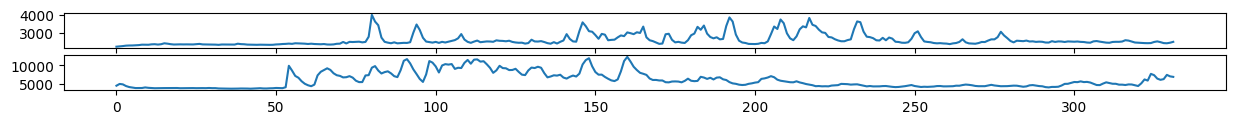

In [59]:
# plot intensities
# TODO normalization?

intensities = df.iloc[0].to_dict()
# all labels that exist within boundaries in time frame
labels = list(intensities.keys())
print(len(labels))
# custom labels
labels=[17,39]

# plot
fig, axs = plt.subplots(len(labels), 1, figsize=(15,len(labels)*0.5))

# Plot using a for loop
for i, label in enumerate(labels):
    try:

        y = intensities[label]
        x = [t for t in range(len(y))]
        axs[i].plot(x, y)
    except KeyError:
        print('Label ' + str(label) + ' does not exist within timeframe.')

# Show the plot
plt.show()